# Classification
- Dos de las tareas de aprendizaje supervisado mas comunes son las regresiones y las clasificaciones
## MNIST
- Es un dataset que se compone de imagenes de numeros escritos a mano etiquetadas con el numero que representan
- Scikit nos da funciones para descargar algunos de los datasets mas populares

In [2]:
import pandas as pd

splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/ylecun/mnist/" + splits["test"])

c:\Users\Simón Jimenez\OneDrive\Documentos\projects\learn_ml\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- sklearn datasets tiene diferntes tipos de funciones
	- **fetch_** para descargar datasets reales, usualmente devuelve un dataframe de pandas y loas etiquetas como un Pandas series
	- **load_** para obtener datasets pequeños que ya vienen con scikit
	- **make_** para generar datasets de prueba
- Los datasets generados vienen en formato (X, y) como arrays de numpy, mientras que los otros datasets vienen en formato sklearn.utils.Bunch
- Los objetos bunch, tienen los atributos DESCR (descripcion del dataset), data (los datos como un array 2d de numpy), target (las etiquetas como un array 1d de numpy)
- Debido a mnist contiene imagenes tener un dataframe no es lo mas optimo por lo que es mejor un array de numpy


In [86]:
import io
import numpy as np
from PIL import Image

def img_to_array(image_data):
	img_bytes = image_data["bytes"]
	img = Image.open(io.BytesIO(img_bytes))
	return np.array(img).flatten()

In [92]:
X_train = np.array(df_train["image"].apply(img_to_array).tolist())
y_train = df_train["label"].to_numpy()

X_test = np.array(df_test["image"].apply(img_to_array).tolist())
y_test = df_test["label"].to_numpy()

In [93]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784), dtype=uint8)

### **1. Cross-validation y distribuciones similares**
- **Cross-validation (validación cruzada)**: Es una técnica para evaluar el rendimiento de un modelo. Divide el conjunto de datos en varios subconjuntos (o *folds*), entrena el modelo con algunos de ellos y valida con los restantes.
  
- **Problema sin mezclar**: Si el conjunto de datos no está mezclado y tiene, por ejemplo, todos los dígitos `0` seguidos de los dígitos `1`, un fold podría terminar sin ejemplos de algunos dígitos (por ejemplo, ningún `1`).
  
- **Solución al mezclar**: La mezcla garantiza que cada fold contenga una distribución representativa de todas las clases (en este caso, dígitos). Esto permite que la validación sea más precisa y generalizable.

---

### **2. Orden y algoritmos sensibles**
- **Sensibilidad al orden**: Algunos algoritmos de aprendizaje automático, como el descenso de gradiente estocástico (SGD), pueden ser sensibles al orden en el que reciben los datos. Si se encuentran con muchas instancias similares seguidas (como múltiples imágenes del mismo dígito), el modelo podría:
  - Aprender patrones redundantes en lugar de generalizar.
  - Converger más lentamente o quedarse atrapado en mínimos locales.

- **Solución al mezclar**: Al mezclar los datos, se asegura que las instancias similares estén distribuidas de manera más uniforme en el conjunto de entrenamiento. Esto ayuda a que el aprendizaje sea más estable y eficiente.

---

### **Conclusión**
Mezclar el conjunto de datos:
1. **Mejora la validación cruzada**: Garantiza que cada fold tenga representaciones balanceadas de las clases.
2. **Mejora el entrenamiento**: Previene que los algoritmos sensibles al orden aprendan patrones sesgados o redundantes debido a la agrupación de datos similares.

Esto es especialmente importante en conjuntos de datos como MNIST, donde las imágenes están agrupadas por clase si no se mezclan explícitamente.


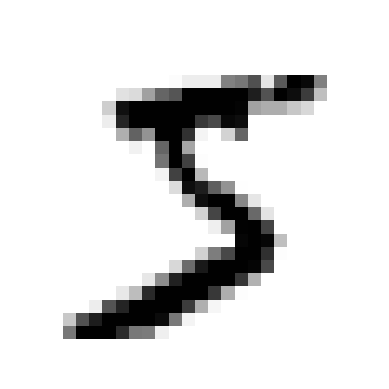

In [94]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
	image = image_data.reshape(28, 28)
	plt.imshow(image, cmap="binary")
	plt.axis("off")

plot_digit(X_train[0])
plt.show()

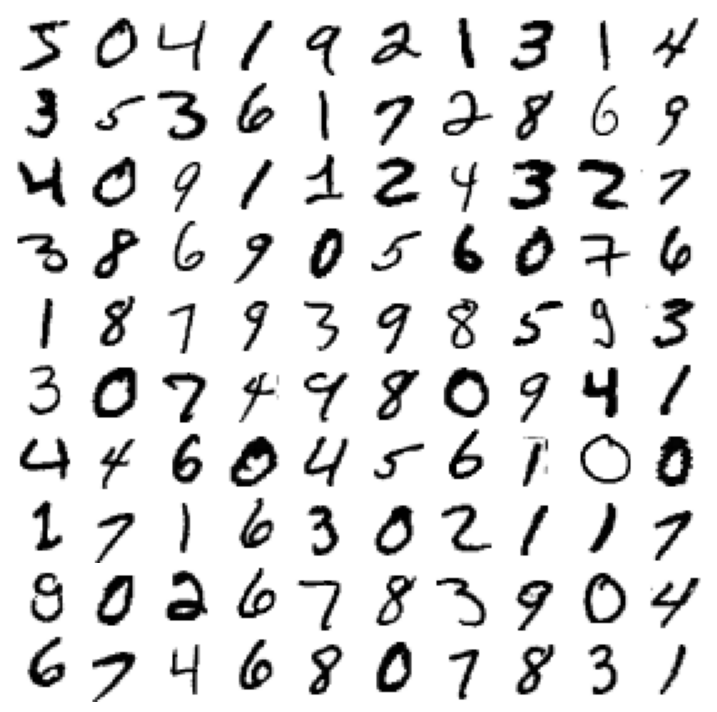

In [95]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X_train[:100]):
	plt.subplot(10, 10, idx + 1)
	plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Training a binary classifier
- Un binary classifier es aquel que es capaz de distinguir entre dos clases

In [105]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

- Usaremos un stochastic gradient classifier, este clasificardor es capaz de manejar grandes datasets, este maneja cada instancia de entrenamiento independientement lo que hace que sea bueno tambien para online learning

In [109]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [114]:
sgd_clf.predict([X_train[0]])

array([ True])

## Performance measures
- Evaluar un clasificador puede ser mas complicado que evaluar un regresor
### Measuring accuracy using cross-validation

In [118]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- usando un dummy clasifier que siempre predice la clase mas frecuente

In [119]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [120]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

- Incluso con un dummy clasifier se obtiene un buen performance, lo que demuestra que accuracy no es una muy buena manera de evaluar el algoritmo, confusion matriz es otra forma de evaluar el algoritmo
- Accuracy es especialmente una mala medida cuando es un dataset skewed lo que signigfica que algunas clases son mucho mas frecuentes que otras
### Implementando cross-validation

In [122]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
	clone_clf = clone(sgd_clf)
	X_train_folds = X_train[train_index]
	y_train_folds = y_train_5[train_index]
	X_test_fold = X_train[test_index]
	y_test_fold = y_train_5[test_index]
	
	clone_clf.fit(X_train_folds, y_train_folds)
	y_pred = clone_clf.predict(X_test_fold)
	n_correct = sum(y_pred == y_test_fold)
	print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


## Confusion Matrix
- Las confusion matrix cuentan el numero de veces que se clasifico una instancia de la clase A como B, para todos los A/B pares
- Para calcular una matriz de confusion se necesita tener un set de predicciones que se puedan comparar, se puede hacer con el test set, pero no es recomendable

In [125]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [126]:
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [127]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

- en una matriz de confusion cada fila representa una clase real, mientras que cada columna representa una clase predicha
- en esta matriz la primera fila representa la clase de imagesnes non-5 y la segunda representa las imagenes de 5
- Lo ideal es que los unicos valores de 0 sean los de la diagonal principal 
- Los falsos negativos son los errores de tipo 2, y los falsos positivos son errores de tipo 1

## ¿Qué es una matriz de confusión?

Una **matriz de confusión** es una herramienta que nos ayuda a evaluar el rendimiento de un modelo de clasificación. En ella, cada fila representa las **clases reales** (lo que realmente es una imagen), y cada columna representa las **clases predichas** (lo que el modelo predice para esa imagen).

Imagina que tienes un modelo que clasifica imágenes en dos categorías: **5** (el número 5) y **no-5** (cualquier otro número). La matriz de confusión te dirá cuántas veces el modelo acertó y cuántas veces se equivocó.

## ¿Cómo se interpreta la matriz de confusión?

La matriz tiene cuatro posibles resultados para cada predicción:

1. **Verdaderos Negativos (True Negatives, TN)**: Imágenes que son **no-5** y que el modelo también predijo correctamente como **no-5**. 
2. **Falsos Positivos (False Positives, FP)**: Imágenes que son **no-5** pero que el modelo **erróneamente** predijo como **5**.
3. **Falsos Negativos (False Negatives, FN)**: Imágenes que son **5** pero que el modelo **erróneamente** predijo como **no-5**.
4. **Verdaderos Positivos (True Positives, TP)**: Imágenes que son **5** y que el modelo **predijo correctamente** como **5**.

## Ejemplo:

En el caso de este modelo, tenemos:

- **Primera fila**: Representa las imágenes de **no-5** (clase real).
  - **53,892 (TN)**: Estas son imágenes que realmente son **no-5** y que el modelo las clasificó correctamente como **no-5**.
  - **687 (FP)**: Son imágenes que realmente son **no-5**, pero el modelo las clasificó erróneamente como **5**.

- **Segunda fila**: Representa las imágenes de **5** (clase real).
  - **1,891 (FN)**: Son imágenes que realmente son **5**, pero el modelo las clasificó erróneamente como **no-5**.
  - **3,530 (TP)**: Son imágenes que realmente son **5**, y el modelo las clasificó correctamente como **5**.

## ¿Qué es un "modelo perfecto"?

Un modelo perfecto tendría solo **verdaderos positivos (TP)** y **verdaderos negativos (TN)**, y no cometería **falsos positivos (FP)** ni **falsos negativos (FN)**. Esto significa que el modelo acertaría en todas las predicciones, y la matriz de confusión sería como una **diagonal** (solo valores no nulos de la esquina superior izquierda a la esquina inferior derecha).

## Resumen:

- La matriz de confusión muestra cuántas veces el modelo acertó y cuántas veces se equivocó.
- Las **verdaderas predicciones** se encuentran en la **diagonal** (de izquierda a derecha).
- Los **errores** aparecen fuera de la diagonal:
  - **Falsos positivos**: El modelo predice **5**, pero la imagen es **no-5**.
  - **Falsos negativos**: El modelo predice **no-5**, pero la imagen es **5**. 

Este análisis ayuda a ver qué tipo de errores comete el modelo y en qué casos necesita mejorar.
## ¿Qué es una matriz de confusión?

Una **matriz de confusión** es una herramienta que nos ayuda a evaluar el rendimiento de un modelo de clasificación. En ella, cada fila representa las **clases reales** (lo que realmente es una imagen), y cada columna representa las **clases predichas** (lo que el modelo predice para esa imagen).

Imagina que tienes un modelo que clasifica imágenes en dos categorías: **5** (el número 5) y **no-5** (cualquier otro número). La matriz de confusión te dirá cuántas veces el modelo acertó y cuántas veces se equivocó.

## ¿Cómo se interpreta la matriz de confusión?

La matriz tiene cuatro posibles resultados para cada predicción:

1. **Verdaderos Negativos (True Negatives, TN)**: Imágenes que son **no-5** y que el modelo también predijo correctamente como **no-5**. 
2. **Falsos Positivos (False Positives, FP)**: Imágenes que son **no-5** pero que el modelo **erróneamente** predijo como **5**.
3. **Falsos Negativos (False Negatives, FN)**: Imágenes que son **5** pero que el modelo **erróneamente** predijo como **no-5**.
4. **Verdaderos Positivos (True Positives, TP)**: Imágenes que son **5** y que el modelo **predijo correctamente** como **5**.

## Ejemplo:

En el caso de este modelo, tenemos:

- **Primera fila**: Representa las imágenes de **no-5** (clase real).
  - **53,892 (TN)**: Estas son imágenes que realmente son **no-5** y que el modelo las clasificó correctamente como **no-5**.
  - **687 (FP)**: Son imágenes que realmente son **no-5**, pero el modelo las clasificó erróneamente como **5**.

- **Segunda fila**: Representa las imágenes de **5** (clase real).
  - **1,891 (FN)**: Son imágenes que realmente son **5**, pero el modelo las clasificó erróneamente como **no-5**.
  - **3,530 (TP)**: Son imágenes que realmente son **5**, y el modelo las clasificó correctamente como **5**.

## ¿Qué es un "modelo perfecto"?

Un modelo perfecto tendría solo **verdaderos positivos (TP)** y **verdaderos negativos (TN)**, y no cometería **falsos positivos (FP)** ni **falsos negativos (FN)**. Esto significa que el modelo acertaría en todas las predicciones, y la matriz de confusión sería como una **diagonal** (solo valores no nulos de la esquina superior izquierda a la esquina inferior derecha).

## Resumen:

- La matriz de confusión muestra cuántas veces el modelo acertó y cuántas veces se equivocó.
- Las **verdaderas predicciones** se encuentran en la **diagonal** (de izquierda a derecha).
- Los **errores** aparecen fuera de la diagonal:
  - **Falsos positivos**: El modelo predice **5**, pero la imagen es **no-5**.
  - **Falsos negativos**: El modelo predice **no-5**, pero la imagen es **5**. 

Este análisis ayuda a ver qué tipo de errores comete el modelo y en qué casos necesita mejorar.


In [128]:
y_train_perfect_predictions  = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

$$
\begin{bmatrix}
TP & FP \\
FN & TN
\end{bmatrix}
$$
## Precisión (Precision)

La **precisión** de un modelo de clasificación se refiere a cuán bien el modelo está haciendo **predicciones positivas correctas**. En otras palabras, de todas las veces que el modelo predijo que una imagen era un **5** (o una clase positiva), ¿cuántas veces acertó realmente?

La **fórmula** es:
$$
\text{Precisión} = \frac{TP}{TP + FP}
$$
- **TP** (True Positives): Casos donde el modelo predijo correctamente que la imagen es un **5**.
- **FP** (False Positives): Casos donde el modelo predijo que la imagen era un **5**, pero realmente no lo era (es decir, es un **no-5**).

**Ejemplo**: Si el modelo predice "5" 10 veces y realmente es un **5** solo 7 veces, entonces la precisión sería de 70% (7 de 10).

Sin embargo, es posible tener una precisión perfecta (100%) si el modelo predice **siempre negativo** y solo hace **una predicción positiva correcta**. Pero este modelo no sería útil, porque ignora la mayoría de los casos positivos. Por eso, la **precisión sola** no siempre es suficiente.

## Recall (Recuerdo o Sensibilidad)

El **recall** o **sensibilidad** mide la capacidad del modelo para **encontrar todos los casos positivos** (es decir, detectar correctamente todos los **5s** en las imágenes). A diferencia de la precisión, el recall se enfoca en **no dejar escapar casos positivos**.

La **fórmula** es:
$$
\text{Recall} = \frac{TP}{TP + FN}
$$
- **TP** (True Positives): Casos donde el modelo predijo correctamente que la imagen era un **5**.
- **FN** (False Negatives): Casos donde el modelo predijo que la imagen era **no-5**, pero en realidad era un **5**.

**Ejemplo**: Si hay 10 imágenes de **5** en total, y el modelo predice correctamente 7 de ellas como **5**, entonces el recall sería del 70% (7 de 10).

## ¿Por qué se usan juntos?

**Precisión** y **recall** se usan juntos porque miden diferentes aspectos del rendimiento del modelo. Un modelo puede tener una alta precisión, pero si no encuentra suficientes casos positivos (es decir, bajo recall), no será útil. Por eso, estas dos métricas se deben considerar juntas al evaluar un modelo.

En resumen:
- **Precisión**: ¿Cuán correcto es el modelo cuando predice positivo?
- **Recall**: ¿Cuántos de los casos positivos reales fueron encontrados por el modelo?

Ambos son importantes, y a veces se busca un equilibrio entre ellos.
## Precision and Recall


In [129]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [130]:
cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(0.8370879772350012)

In [131]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [133]:
cm[1, 1] / (cm[1, 1] + cm[1, 0])

np.float64(0.6511713705958311)

- Esto quiere decir que cuando detecta una imagen que es 5 esta correcto en el 83.7% de las veces
- Sin embargo solo detecta el 65.1% de los 5
- Se puede juntar la precision y el recall para tener una metrica mas concisa esta se conoce como: $F_1 score$  
- Esta es el promedio armonico entre la precision y el recall, esto ya que este promedio armonico le da mas peso a los valores bajos por lo que para que $F_1 score$ sea alto precision y recall tienen que ser altos
- Formula de $F_1 score$:

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} 
= 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} 
= \frac{\text{TP}}{\text{TP} + \frac{\text{FN} + \text{FP}}{2}}
$$

In [134]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

- $F_1$ favorece los modelos con una precision y recall similar, sin embargo a veces se puede requerir una alta precision o un alto recall
- Incrementar la precision reduce el recall y vice versa
## The Precision/Recall Trade-off
- Tomando como ejemplo un SGDClassifier, el cual para cada instancia calcula un puntaje basada en una funcion de decision, si la funcion supera cierto limite, este asignara dicha instancia a dicha clase, de lo contrario no.
- En este tipo de algoritmo subir dicho limite aumentara la precision pero reducira el recall, y decrementar el limite subira el recall pero disminuira la precision, ya que toma mas instancias como 5 pero tendra mas errores
- Scikit no permite modificar el threshold (limite) pero si nos da acceso a la funcion de decision

In [139]:
y_scores = sgd_clf.decision_function([X_train[0]])
y_scores

array([2164.22030239])

- SGDCLassifier usa un threshold de 0

In [140]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [141]:
y_some_digit_pred

array([ True])

- Aumentar el threshold reduce el recall 

In [142]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- Realizar cross validation pero regresando los puntajes de la funcion de decision

In [143]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

#### **1. ¿Qué hace `precision_recall_curve()`?**

Esta función calcula los valores de **precisión** y **recall** (también llamado sensibilidad) para diferentes valores de **umbral** que se pueden usar para clasificar los datos.

En un problema de clasificación binaria, el modelo genera puntuaciones (por ejemplo, probabilidades) que se pueden transformar en etiquetas de clase (0 o 1) mediante un **umbral de decisión**. Por defecto, el umbral típico es 0.5, pero cambiándolo puedes influir en la precisión y el recall.

---

#### **2. ¿Cómo funciona?**

- **Inputs**:
  - `y_train_5`: El conjunto de **etiquetas reales** (verdaderas), en este caso, un array binario donde cada valor es 0 o 1.
  - `y_scores`: Las **puntuaciones** que da el modelo para cada ejemplo (por ejemplo, probabilidades de pertenecer a la clase positiva).

- **Outputs**:
  - `precisions`: Un array con los valores de precisión obtenidos para cada posible umbral.
  - `recalls`: Un array con los valores de recall correspondientes a esos mismos umbrales.
  - `thresholds`: Los valores de umbral para los cuales se calculan las precisiones y recalls.

---

#### **3. Detalles importantes:**

- **Valores extremos:**
  - La función siempre agrega un último punto con:
    - Precisión = 0
    - Recall = 1  
      Esto representa un umbral infinito, donde ningún ejemplo sería clasificado como positivo (y por lo tanto, precisión es 0 porque no hay predicciones positivas).

- **Relación entre precisión, recall y umbral:**
  - Al **bajar el umbral**, el modelo clasifica más ejemplos como positivos, lo que **aumenta el recall** pero puede **reducir la precisión**.
  - Al **aumentar el umbral**, el modelo clasifica menos ejemplos como positivos, lo que **aumenta la precisión** pero puede **reducir el recall**.

In [170]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

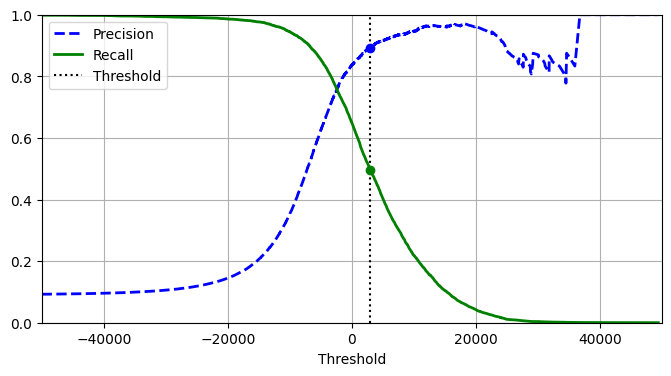

In [171]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="Threshold")


idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend()
plt.show()

- La linea de precision puede ser mas irregular ya que en algunas ocasiones al subir el umbral la precision puede bajar, mientras al subir el umbral el recall siempre va a bajar
- Graficar la precision directamente en contra del recall tambien es util

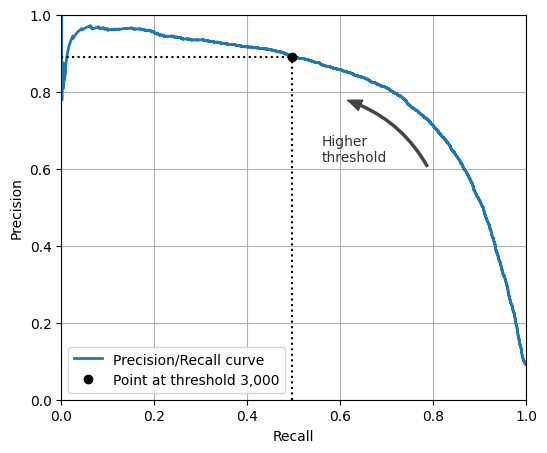

In [196]:
import matplotlib.patches as patches

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0, precisions[idx]], "k:")
plt.plot([0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot(recalls[idx], precisions[idx], "ko", label="Point at threshold 3,000")

plt.gca().add_patch(patches.FancyArrowPatch(
	(0.79, 0.60), (0.61, 0.78),
	connectionstyle="arc3,rad=.2",
	arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
	color="#444444"
))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend()
plt.show()

In [202]:
idx_for_90_precision = (precisions >= 0.90).argmax() 
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [203]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [206]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The Roc Curve
- Receiver operating characteristic
### **1. ¿Qué es la curva ROC?**
La **curva ROC (Receiver Operating Characteristic)** es una herramienta que se usa para evaluar la capacidad de un clasificador binario. En lugar de graficar **precisión** frente a **recall** (como en la curva precisión/recall), la curva ROC grafica:

- **Eje Y:** **Tasa de verdaderos positivos (TPR)**, que es igual a **recall** o **sensibilidad**.
- **Eje X:** **Tasa de falsos positivos (FPR)**, que mide la proporción de negativos clasificados incorrectamente como positivos.

---

### **2. Conceptos clave:**
#### **Tasa de verdaderos positivos (TPR):**
También llamada **recall** o **sensibilidad**, mide qué proporción de los ejemplos positivos fueron correctamente identificados por el clasificador.

Fórmula:
$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

#### **Tasa de falsos positivos (FPR):**
También llamada **fall-out**, mide qué proporción de los ejemplos negativos fueron clasificados incorrectamente como positivos.

Fórmula:
$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

#### **Relación con la especificidad (TNR):**
- La **tasa de verdaderos negativos (TNR)** (también llamada **especificidad**) mide qué proporción de los ejemplos negativos fueron clasificados correctamente.
- La relación es:
$$
  \text{FPR} = 1 - \text{TNR}
$$ 
  Esto significa que un aumento en la FPR reduce la especificidad.

---

### **3. ¿Qué muestra la curva ROC?**
La curva ROC muestra cómo cambian la TPR y la FPR al variar el **umbral de decisión** del clasificador. Por ejemplo:
- Un **umbral bajo** clasifica más instancias como positivas, lo que **aumenta la TPR pero también la FPR**.
- Un **umbral alto** clasifica menos instancias como positivas, lo que **reduce tanto la TPR como la FPR**.

---

### **4. Interpretación:**
- Una curva ROC **ideal** tendría:
  - Alta TPR (sensibilidad).
  - Baja FPR (pocos falsos positivos).
  - Esto se traduce en una curva que está lo más cerca posible del **esquina superior izquierda** del gráfico.
  
- **Clasificador perfecto:** La curva pasaría exactamente por (0, 1), lo que significa:
  - FPR = 0 (sin falsos positivos).
  - TPR = 1 (todos los positivos son detectados).

---

### **5. Métrica derivada: AUC-ROC**
- El **AUC (Área Bajo la Curva)** mide el área bajo la curva ROC.
- Rango:
  - **1.0**: Clasificador perfecto.
  - **0.5**: Clasificador aleatorio (curva diagonal).

---

### **6. Comparación con la curva precisión/recall:**
- La curva ROC es útil cuando las clases están balanceadas (positivos y negativos en proporciones similares).
- La curva precisión/recall es mejor cuando las clases están desequilibradas (por ejemplo, pocos positivos y muchos negativos).

---

### **7. Ejemplo práctico:**
Imagina un modelo que predice si un email es spam o no:
- **Tasa de verdaderos positivos (TPR):** Proporción de emails spam detectados correctamente.
- **Tasa de falsos positivos (FPR):** Proporción de emails legítimos que se clasifican incorrectamente como spam.

La curva ROC te ayuda a evaluar cómo de bien separa el modelo estas dos categorías.


In [208]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

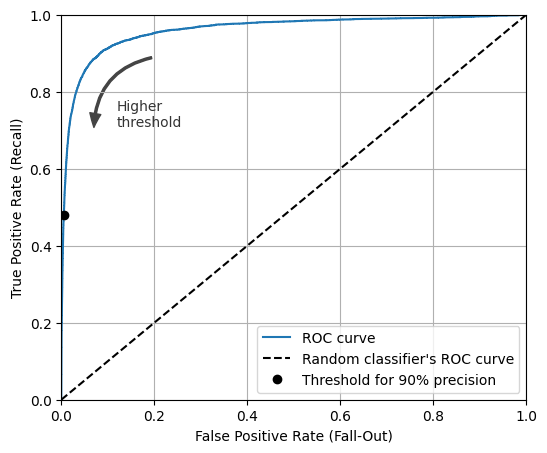

In [218]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], "k--", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko",label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
	(0.2, 0.89), (0.07, 0.7),
	connectionstyle="arc3, rad=.4",
	arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
	color="#444444"
))
plt.text(0.12, 0.71 , "Higher\nthreshold", color="#333333")

plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid()
plt.legend()
plt.show()

- Tambien hay un trade-off entre el tpr y el fpr, la linea punteada representa la roc curve de un random classifier, un buen clasificador se aleja de dicha curva
- Una forma de comparar clasificadores es medir el area debajo de la roc (AUC), un area de 1 es un un clasificador perfecto, mientras que un area de 0.5 es un random classifier

In [219]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

- si se tiene un clasificador de una clase extraña es recomendable usar PR curve, tambien cuando importan mas los falsos positivos que los falsos negativos
- De lo contrario es preferible usar ROC curve 
- RandomForestClassifier no usa una funcion de decision, sino que devuelve las probabilidades de clase de cada instancia

In [220]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [221]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

- Las probabilidades que da RandomForestClassifier no son probabilidades reales sino estimadas
### **1. ¿Qué significa "probabilidades estimadas"?**

Cuando un modelo predice la probabilidad de que una instancia pertenezca a una clase (por ejemplo, "positivo"), esas probabilidades **no siempre reflejan la realidad con exactitud**.

Por ejemplo:
- Si un modelo predice que hay un **60% de probabilidad** de que una imagen sea positiva:
  - En un mundo ideal, 60 de cada 100 imágenes con esa predicción deberían ser realmente positivas.
  - Pero en la práctica, puede que 94 de cada 100 imágenes sean positivas, lo que muestra que las probabilidades del modelo están **subestimadas**.

---

### **2. ¿Qué significa que las probabilidades no estén "calibradas"?**

- Un modelo está **bien calibrado** si las probabilidades que predice coinciden con la realidad.
  - Ejemplo: Si el modelo dice "50% de probabilidad", eso debería significar que, en promedio, la mitad de los casos realmente pertenecen a esa clase.
- Si un modelo predice probabilidades que son consistentemente **muy bajas** o **muy altas** en comparación con la realidad, se dice que está **mal calibrado**.
  - Ejemplo: Si predice "50% de probabilidad" pero realmente el 94% de los casos son positivos, entonces las probabilidades están mal calibradas.

---

### **3. ¿Por qué es importante calibrar las probabilidades?**

Si las probabilidades del modelo no son confiables:
- Puedes tomar decisiones erróneas basadas en esas probabilidades.
- Por ejemplo, en un sistema médico, un modelo que subestima las probabilidades podría ignorar pacientes que necesitan tratamiento urgente.

La calibración ajusta las probabilidades estimadas para que reflejen mejor la realidad.

---

### **4. ¿Cómo se calibra un modelo?**

El paquete `sklearn.calibration` de Scikit-learn ofrece herramientas para ajustar las probabilidades estimadas del modelo. Esto se hace usando técnicas como:
- **Calibración de Platt**: Ajusta las probabilidades con un modelo logístico.
- **Isotonic regression**: Una técnica no paramétrica que ajusta las probabilidades.

Con estas herramientas, puedes corregir las probabilidades para que estén más alineadas con los resultados reales.


In [222]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [224]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, threshold_forest = precision_recall_curve(y_train_5, y_scores_forest)

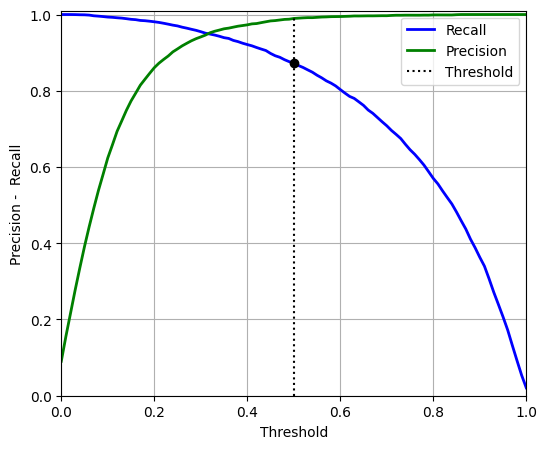

numpy.ndarray

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(threshold_forest, recalls_forest[:-1], "b-", label="Recall", linewidth=2)
plt.plot(threshold_forest, precisions_forest[:-1], "g-", label="Precision", linewidth=2)
plt.vlines(0.5, 0, 1.0, "k", "dotted", label="Threshold")

idx_threshold = (threshold_forest >= 0.5).argmax()
plt.plot(threshold_forest[idx_threshold], recalls_forest[idx_threshold], "ko")
plt.plot(threshold_forest[idx_threshold], precisions_forest[idx_threshold], "ko")

plt.xlabel("Threshold")
plt.ylabel("Precision -  Recall")
plt.axis([min(threshold_forest) , max(threshold_forest), 0, 1.01])
plt.legend()
plt.grid()
plt.show()
type(recalls_forest)

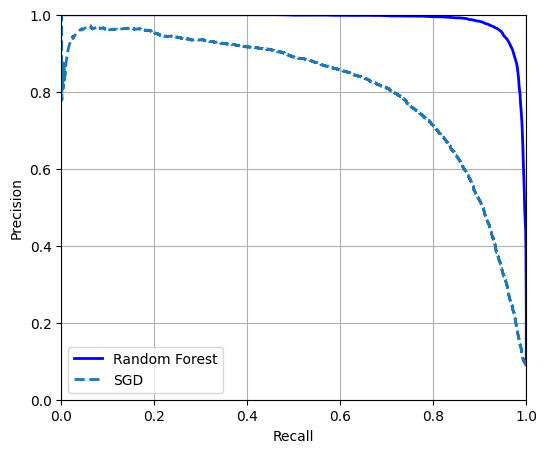

In [228]:
plt.figure(figsize=(6, 5))
plt.plot(recalls_forest, precisions_forest, "b-", label="Random Forest", linewidth=2)
plt.plot(recalls, precisions, "--", label="SGD", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.axis([0, 1, 0, 1])
plt.grid()
plt.show()

In [235]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [234]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)